# Project Assignment: Movie Pairing Recommender System
## Objective
Develop a recommender system that pairs two movies based on complementary genres, themes, or viewer preferences, similar to the concept used on Date Night Movies.

#### Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Datasets
Les datasets suivant vont être utilsés :

MovieLens Dataset: MovieLens
https://files.grouplens.org/datasets/movielens/ml-1m.zip

IMDb Dataset: IMDb Datasets:
- name.basics.tsv.gz
- title.basics.tsv.gz\
https://datasets.imdbws.com/


## Tasks

1. **Data Collection and Preprocessing**
   - Download the MovieLens and IMDb datasets.


La première étape est de télécharger les datasets.

In [2]:
# Load the data 
title_basics_df = pd.read_csv('title.basics.tsv', sep='\t')
name_basics_df = pd.read_csv('name.basics.tsv', sep='\t')

movies_dat_df = pd.read_csv('movielens/movies.dat', sep='::', header=None, engine='python', names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
ratings_dat_df = pd.read_csv('movielens/ratings.dat', sep='::', header=None, engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
users_dat_df = pd.read_csv('movielens/users.dat', sep='::', header=None, engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')

C:\Users\user_\AppData\Local\Temp\ipykernel_12200\2416125625.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics_df = pd.read_csv('title.basics.tsv', sep='\t')


Ensuite on le affiches rapidement pour avoir une idée des données visuellement.

In [3]:
# Set display options to avoid truncation
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap in the display

# Simple look at the data 
print('**********-------IMDB Title Basics----------**********')
print(title_basics_df.head(3))
print('**********-------IMDB Name Basics----------**********')
print(name_basics_df.head(3))
print('**********-------Movies MovieLens----------**********')
print(movies_dat_df.head(3))
print('**********-------Ratings MovieLens----------**********')
print(ratings_dat_df.head(3))
print('**********-------Users MovieLens----------**********')
print(users_dat_df.head(3))

**********-------IMDB Title Basics----------**********
      tconst titleType            primaryTitle           originalTitle isAdult startYear endYear runtimeMinutes                    genres
0  tt0000001     short              Carmencita              Carmencita       0      1894      \N              1         Documentary,Short
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens       0      1892      \N              5           Animation,Short
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot       0      1892      \N              5  Animation,Comedy,Romance
**********-------IMDB Name Basics----------**********
      nconst      primaryName birthYear deathYear                   primaryProfession                           knownForTitles
0  nm0000001     Fred Astaire      1899      1987        actor,miscellaneous,producer  tt0072308,tt0050419,tt0053137,tt0027125
1  nm0000002    Lauren Bacall      1924      2014  actress,soundtrack,archive_footage

2. **Feature Engineering**
  - Extract relevant features, you can choose the basic ones or create composite ones. A few examples are genres, directors, cast, and ratings.
  

C'est important de connaitre les dimensions des données donc je décide de les afficher.

In [4]:
# Print the size of the datasets
print('**********-------IMDB Title Basics----------**********')
print(title_basics_df.shape)
print('**********-------IMDB Name Basics----------**********')
print(name_basics_df.shape)
print('**********-------Movies MovieLens----------**********')
print(movies_dat_df.shape)
print('**********-------Ratings MovieLens----------**********')
print(ratings_dat_df.shape)
print('**********-------Users MovieLens----------**********')
print(users_dat_df.shape)

**********-------IMDB Title Basics----------**********
(10856095, 9)
**********-------IMDB Name Basics----------**********
(13575526, 6)
**********-------Movies MovieLens----------**********
(3883, 3)
**********-------Ratings MovieLens----------**********
(1000209, 4)
**********-------Users MovieLens----------**********
(6040, 5)


De même pour les colonnes.


In [5]:
# Get the columns of the movies datasets to see on which columns we can join
print('**********-------IMDB Title Basics----------**********')
print(title_basics_df.columns)
print('**********-------Movies MovieLens----------**********')
print(movies_dat_df.columns)

**********-------IMDB Title Basics----------**********
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')
**********-------Movies MovieLens----------**********
Index(['MovieID', 'Title', 'Genres'], dtype='object')


Ces informations ont été extraites du README de Movie Lens Datasets:\
https://developer.imdb.com/non-commercial-datasets/
1. name.basics
- primaryName (string)– name by which the person is most often credited
- birthYear – in YYYY format
- deathYear – in YYYY format if applicable, else '\N'
- primaryProfession (array of strings)– the top-3 professions of the person
- knownForTitles (array of tconsts) – titles the person is known for

Je ne vais pas utiliser ce dataset par manque de ressources.\
(Cela sera expliqué plus tard)

2. title.basics.tsv.gz
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title


Ici j'applique plusieurs prétraitements sur les données.\
Pour les titres de films:
- Suppression des caractères spéciaux
- Suppression des années, puis création d'une colonne pour stocker ces années

Pour les type de d'assets:
- Je garde uniquement les films
- J'enlève les autres types d'assets : TVseries, short, etc.


In [6]:
pd.set_option('display.max_columns', None)  # Show all columns

# Apply preprocessing to the titles : remove special characters, lower case, remove spaces, punctuation
# Remove special characters
title_basics_df['primaryTitle'] = title_basics_df['primaryTitle'].str.replace('[^A-Za-z0-9\s]+', '')
title_basics_df['originalTitle'] = title_basics_df['originalTitle'].str.replace('[^A-Za-z0-9\s]+', '') # .str.lower() #.str.replace(' ', '')
movies_dat_df['Title'] = movies_dat_df['Title'].str.replace('[^A-Za-z0-9\s]+', '')

# Keep only movies type of "titleType" in the IMDB dataset
title_basics_df = title_basics_df[title_basics_df['titleType'] == 'movie']

# Create a new column with the Movie Lens titles, because it contains the year of the movie
# Ex :"Toy Story (1995)" -> "Toy Story
movies_dat_df['Year'] = movies_dat_df['Title'].str.extract(r"\((\d{4})\)", expand=False)
movies_dat_df['Title'] = movies_dat_df['Title'].str.replace(r"\(\d{4}\)", "", regex=True).str.strip()

print('**********-------IMDB Title Basics----------**********')
print(title_basics_df.head(3))
print('**********-------Movies MovieLens----------**********')
print(movies_dat_df.head(3))

**********-------IMDB Title Basics----------**********
        tconst titleType                   primaryTitle                  originalTitle isAdult startYear endYear runtimeMinutes                  genres
8    tt0000009     movie                     Miss Jerry                     Miss Jerry       0      1894      \N             45                 Romance
144  tt0000147     movie  The Corbett-Fitzsimmons Fight  The Corbett-Fitzsimmons Fight       0      1897      \N            100  Documentary,News,Sport
498  tt0000502     movie                       Bohemios                       Bohemios       0      1905      \N            100                      \N
**********-------Movies MovieLens----------**********
   MovieID             Title                        Genres  Year
0        1         Toy Story   Animation|Children's|Comedy  1995
1        2           Jumanji  Adventure|Children's|Fantasy  1995
2        3  Grumpier Old Men                Comedy|Romance  1995


1. **Data Collection and Preprocessing**
  - Merge datasets to include movie ratings, genres, and metadata.


In [7]:
# Merge the two datasets based on the movies that are presents in both datasets (IMDB and MovieLens)
# We will use the title_basics_df and movies_dat_df to merge the two datasets
# The merge is based on the title key (primaryTitle and Title) because the other features may vary
pd.set_option('display.max_columns', None)  # Show all columns
merged_df = pd.merge(movies_dat_df, title_basics_df, left_on='Title', right_on='primaryTitle', how='inner')
print(merged_df.head(3))

   MovieID             Title                        Genres  Year     tconst titleType      primaryTitle     originalTitle isAdult startYear endYear runtimeMinutes                      genres
0        1         Toy Story   Animation|Children's|Comedy  1995  tt0114709     movie         Toy Story         Toy Story       0      1995      \N             81  Adventure,Animation,Comedy
1        2           Jumanji  Adventure|Children's|Fantasy  1995  tt0113497     movie           Jumanji           Jumanji       0      1995      \N            104     Adventure,Comedy,Family
2        3  Grumpier Old Men                Comedy|Romance  1995  tt0113228     movie  Grumpier Old Men  Grumpier Old Men       0      1995      \N            101              Comedy,Romance


In [8]:
print(merged_df) # Open in Data Wrangler extension to see the data

      MovieID                        Title                        Genres  Year      tconst titleType                 primaryTitle                originalTitle isAdult startYear endYear runtimeMinutes                      genres
0           1                    Toy Story   Animation|Children's|Comedy  1995   tt0114709     movie                    Toy Story                    Toy Story       0      1995      \N             81  Adventure,Animation,Comedy
1           2                      Jumanji  Adventure|Children's|Fantasy  1995   tt0113497     movie                      Jumanji                      Jumanji       0      1995      \N            104     Adventure,Comedy,Family
2           3             Grumpier Old Men                Comedy|Romance  1995   tt0113228     movie             Grumpier Old Men             Grumpier Old Men       0      1995      \N            101              Comedy,Romance
3           4            Waiting to Exhale                  Comedy|Drama  1995   tt01148

#### Features selection
En faisant une analyse globale des données avec l'extension Data Wrangler sur VS Code,\
je me suis apperçu de plusieurs choses :
- Il y a beaucoup d'informations sur un seul film dans IMDB qui ne sont pas présente dans movie lens.\
Je décide donc de ne garder qu'une ligne par film dans mon dataframe de films.
- Les données dans endYear était toutes des '\N'.
- Comme il n'y a que des films, la colonne du genre n'est plus utile


###### Les colonnes qui vont donc disparaître sont donc :
- endYear car nulle "TV Series end year. ‘\N’ for all other title types" depuis la documentation du dataset IMDB.\
En fait ici on ne traite que les films donc c'est logique que cette colonne soit nulle
- originalTitle car nulle
- primaryTitle car nulle
- isAdult car nulle sauf pour 3 films
- tconst car ne donne aucune information supplémentaire sur le film 
"tconst (string) - alphanumeric unique identifier of the title" depuis la documentation du dataset IMDB.

- Concernant les ratings, je supprime les timestamps car on a pas besoin.


In [9]:
distinct_movies = merged_df.drop_duplicates(subset=['MovieID'])
# We don't need the titleType column anymore so we can drop it
# Print the number of '\N' values in "endYear" column
print(f" different values in movies df : {distinct_movies['endYear'].value_counts()}")
print(f"Shape of movie df : {distinct_movies.shape}")
# Count the number of different orignial titles and primary titles
print(f"difference between primaryTitle and originalTitle : {distinct_movies['primaryTitle'].nunique() - distinct_movies['originalTitle'].nunique()}")

 different values in movies df : endYear
\N    2563
Name: count, dtype: int64
Shape of movie df : (2563, 13)
difference between primaryTitle and originalTitle : 2


Je décide aussi de faire une colonne pour les genres de films.\
Plus expressive, et plus simple à manipuler.

In [10]:
# Convert both genre columns to sets and merge them
merged_df['merged_genres'] = merged_df.apply(lambda row: set(row['Genres'].split('|') + row['genres'].split(',')), axis=1)

# Remove any empty strings that might have been introduced
merged_df['merged_genres'] = merged_df['merged_genres'].apply(lambda x: set(filter(None, x)))

# Convert back to a sorted list and then to a string
merged_df['merged_genres'] = merged_df['merged_genres'].apply(lambda x: '|'.join(sorted(x)))

# Drop the original genre columns if you no longer need them
merged_df = merged_df.drop(columns=['Genres', 'genres'])

# Rename the new column to 'Genres' if desired
merged_df = merged_df.rename(columns={'merged_genres': 'Genres'})

pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks
print(merged_df[['MovieID', 'Title', 'Year', 'runtimeMinutes', 'Genres']].head(5))

   MovieID                        Title  Year runtimeMinutes                                      Genres
0        1                    Toy Story  1995             81       Adventure|Animation|Children's|Comedy
1        2                      Jumanji  1995            104  Adventure|Children's|Comedy|Family|Fantasy
2        3             Grumpier Old Men  1995            101                              Comedy|Romance
3        4            Waiting to Exhale  1995            124                        Comedy|Drama|Romance
4        5  Father of the Bride Part II  1995            106                       Comedy|Family|Romance


In [11]:
distinct_movies = merged_df.drop_duplicates(subset=['MovieID'])
distinct_movies = distinct_movies.drop(columns=['titleType', 'endYear', 'originalTitle', 'primaryTitle', 'isAdult', 'tconst'])
# Remove the timestamp column from the ratings dataset
ratings_dat_df = ratings_dat_df.drop(columns=['Timestamp'])

Toujours dans la partie feature selection, je voulais ajouter/faire tout cela :
```
- Les colonnes primaryTitle originalTitle et Title sont redondantes
    - Enfait les caractéristiques intéressantes & aditionnelles en provenance de IMDB sont les intervenants du film : réalisateur producteur etc.
    - Il y a aussi d'autres informations comme le genre du film, mais c'est surtout les intervenants qui rajoutent de l'information ici.
    - En effet, je prends l'exemple de ma mère : elle aime bien regarder des films de Johnny Depp alors si on lui recommande un film dans lequel il a joué alors elle sera satisfaite, peu importe le genre.
```
Mais malheureusement mon pc ne supportait pas les opérations d'explode puis de merge.
Dans la suite je ne vais donc pas utiliser le dataset des names

2. **Feature Engineering**
- Create a user-item interaction matrix for collaborative filtering.

La user-item interaction matrix est une matrice qui contient les notes des utilisateurs pour les films.\
La matrice est creuse, car un utilisateur ne note pas tous les films.\
Elle est très utile pour pouvoir visualiser l'ensemble des notes des utilisateurs pour les films.

In [12]:
print(distinct_movies.head(3))

   MovieID             Title  Year startYear runtimeMinutes                                      Genres
0        1         Toy Story  1995      1995             81       Adventure|Animation|Children's|Comedy
1        2           Jumanji  1995      1995            104  Adventure|Children's|Comedy|Family|Fantasy
2        3  Grumpier Old Men  1995      1995            101                              Comedy|Romance


In [13]:
# Filter the ratings to include only those movies that are in the distinct_movies dataframe
filtered_ratings_df = ratings_dat_df[ratings_dat_df['MovieID'].isin(distinct_movies['MovieID'])]

# Create a user-item interaction matrix for collaborative filtering
user_item_matrix = filtered_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
print(user_item_matrix.head(3))
print(user_item_matrix.shape)

MovieID  1     2     3     4     5     6     7     8     9     10    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    31    33    34    35    36    37    38    39    40    41    42    43    44    45    46    48    49    52    53    55    56    57    61    62    63    65    66    67    69    70    71    72    74    75    76    77    83    84    85    86    87    88    89    92    93    94    95    98    100   101   102   103   104   107   108   110   111   112   113   114   116   118   120   122   123   128   129   130   131   132   133   134   135   136   137   139   145   149   150   151   153   155   156   157   158   159   160   161   162   163   164   167   168   169   170   171   172   173   174   175   176   177   179   180   182   183   184   186   187   189   190   193   194   195   196   198   201   202   203   204   205   206   208   209   210   212   215   216   218   220   222   223   224   225   226   227   228   229   2

In [14]:
# Find users who have the most ratings
# They will be used to test the recommendation method later
user_ratings = filtered_ratings_df['UserID'].value_counts()
user_ratings_no_axis = user_ratings.reset_index()
user_ratings_no_axis.columns = ['UserID', 'Number of Ratings']
print(user_ratings_no_axis.head(3))

# print the number of ratings for user 1 and 2
print("------------------")
print("The number of ratings for user 1 and 2 are :")
print(user_ratings[1])
print(user_ratings[2])


   UserID  Number of Ratings
0    4169               1557
1    1680               1314
2    4277               1190
------------------
The number of ratings for user 1 and 2 are :
41
89


2. **Feature Engineering**
- Understand how to combine user data to get data for the couple of users.

Ici je vais simplement prendre les notes des utilisateurs pour les films.\
Puis faire la moyenne des notes pour chaque film.\
Cela va me donner une note moyenne pour chaque film, que je vais trier par ordre décroissant.\
Cela va me permettre de voir les films les mieux notés par le couple d'utilisateur.

In [15]:
# Sample function to combine user data
def combine_user_data(user1_id, user2_id, user_item_matrix):
    user1_ratings = user_item_matrix.loc[user1_id]
    user2_ratings = user_item_matrix.loc[user2_id]

    # Combine ratings by averaging
    combined_ratings = pd.concat([user1_ratings, user2_ratings], axis=1)
    combined_ratings.columns = ['User1', 'User2']
    
    # Average the ratings where both users have rated the movie, otherwise take the non-zero rating
    combined_ratings['Combined'] = combined_ratings.mean(axis=1)
    combined_ratings['Combined'] = combined_ratings['Combined'].fillna(0)  # Fill NaNs with 0 (for unseen movies)
    
    return combined_ratings['Combined']

# Example usage with user IDs 1 and 2
#user1_id = 4169
user1_id = 1
user2_id = 2
#user2_id = 1680
combined_user_data = combine_user_data(user1_id, user2_id, user_item_matrix)

# Print the result
combined_user_data_no_index = combined_user_data.reset_index()
combined_user_data_no_index.columns = ['MovieID', 'Combined Rating']
print(combined_user_data_no_index)


      MovieID  Combined Rating
0           1              2.5
1           2              0.0
2           3              0.0
3           4              0.0
4           5              0.0
...       ...              ...
2455     3947              0.0
2456     3948              0.0
2457     3949              0.0
2458     3950              0.0
2459     3951              0.0

[2460 rows x 2 columns]


In [16]:
# Function to recommend movies for a combined user profile
def recommend_movies_for_combined_user(combined_user_data, distinct_movies, num_recommendations=5):
    # Find top-rated movies in the combined user profile
    top_movies = combined_user_data.sort_values(ascending=False).head(num_recommendations)
    
    # Get movie details from distinct_movies dataframe
    recommended_movies = distinct_movies[distinct_movies['MovieID'].isin(top_movies.index)]
    
    return recommended_movies

pd.set_option('display.expand_frame_repr', False)  # Prevent line breaks

# Recommendations for combined user data
recommendations = recommend_movies_for_combined_user(combined_user_data, distinct_movies , num_recommendations=5)
print(f"The top {len(recommendations)} movie recommendations for combined user profile:")
print(recommendations)
# Verify the recommendations by checking the ratings of user1 and user2

user1_ratings = user_item_matrix.loc[user1_id, recommendations['MovieID']]
user2_ratings = user_item_matrix.loc[user2_id, recommendations['MovieID']]

user1_ratings = user1_ratings.reset_index()
user2_ratings = user2_ratings.reset_index()

user1_ratings.columns = ['MovieID', 'Rating']
user2_ratings.columns = ['MovieID', 'Rating']

print(f"user1 (id={user1_id}) ratings for list of recommendations:")
print(user1_ratings)
print(f"user1 (id={user2_id}) ratings for list of recommendations:")
print(user2_ratings)


The top 5 movie recommendations for combined user profile:
      MovieID                            Title  Year startYear runtimeMinutes            Genres
2218     1193  One Flew Over the Cuckoo's Nest  1975      1975            133             Drama
2312     1246               Dead Poets Society  1989      1989            128      Comedy|Drama
3668     1962               Driving Miss Daisy  1989      1989             99      Comedy|Drama
3778     2028              Saving Private Ryan  1998      1998            169  Action|Drama|War
5640     3105                       Awakenings  1990      1990            121   Biography|Drama
user1 (id=1) ratings for list of recommendations:
   MovieID  Rating
0     1193     5.0
1     1246     4.0
2     1962     4.0
3     2028     5.0
4     3105     5.0
user1 (id=2) ratings for list of recommendations:
   MovieID  Rating
0     1193     5.0
1     1246     5.0
2     1962     5.0
3     2028     4.0
4     3105     4.0


3. **Model Development**
   - Implement a recommender system algorithm (e.g., matrix factorization) to predict the rating of a movie by a couple of users.

Ici je voulais savoir le nombre de films notés par chaque utilisateur.\
Cela peut être utile pour savoir si en général les utilisateurs sont très actifs ou non.\
Car en fonction de cela, on peut adapter le modèle de recommandation.\
Ici sans surprise, on voit que la plupart des utilisateurs ont noté moins de 200 films.

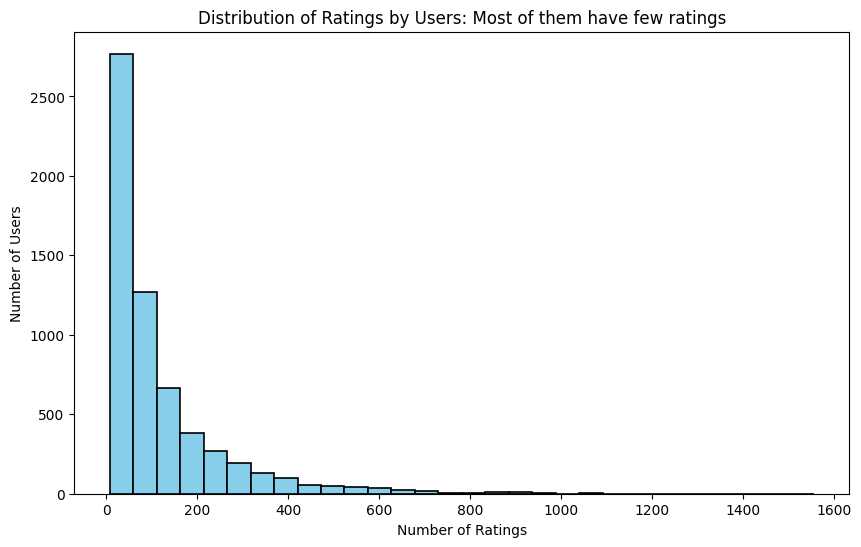

In [17]:
# Plot the distribution of ratings by users
plt.figure(figsize=(10, 6))
plt.hist(user_ratings, bins=30, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Ratings by Users: Most of them have few ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

Le modèle que j'ai choisi pour la recommandation est le modèle Alternating Least Squares (ALS) .\
Il provient de la librairie `implicit` développée par **benfred** et est disponible grâce à ce lien : https://github.com/benfred/implicit  \
ALS permet d'implémenter la factorisation de matrices pour la recommandation.\
La factorisation de matrices permet de répondre à plusieurs problèmes de dans le cadre de systèmes de recommandations.\
- > Popularity bias : Une minorité de film rassemble la majorité de notes. Les films qui sont le moins bien notés sont ainsi moins vus et cela créé un cercle vicieux pour eux. 
>
- > Cold start : Certains utilisateurs (notamment les nouveaux) n'ont pas ou ont très peu donné de notes. Ce qui rend la prédiction plus difficile.
>
- > Scalability issue : les calculs sont très longs car on est amenés à manipuler une grande quantité d'information que ce soit sur les users ou les items 
>

J'ai choisi le modèle ALS pour plusieurs raisons :
- > ALS Handles Sparsity: Effectively works with sparse datasets. 
>
Ce qui est le cas ici car d'après l'histogramme précédent, on s'attend a avoir une matrice (très) creuse.\
- > The main strength of the algorithm is the effectiveness and the computational efficiency.
>
Ce qui est toujours un plus.
- > Scalable: Suitable for large-scale applications.
>
Je n'ai pas voulu paralléliser ALS en utilisant PySpark, car étant donné le nombre de films et d'utilisateurs, je ne pense pas que cela soit nécessaire.\
En fait la librairie implicit est déjà très performante et je n'ai pas eu de problèmes de performance avec elle.

In [18]:
from sklearn.preprocessing import MinMaxScaler
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sparse

def normalize_ratings(ratings):
    scaler = MinMaxScaler((0, 1))
    normalized_ratings = ratings.copy()
    for column in normalized_ratings.columns:
        non_zero_mask = normalized_ratings[column] > 0
        normalized_ratings.loc[non_zero_mask, column] = scaler.fit_transform(normalized_ratings.loc[non_zero_mask, column].values.reshape(-1, 1)).flatten()
    return normalized_ratings, scaler

def train_als_model(user_item_matrix, factors=50, regularization=0.01, iterations=50):
    normalized_ratings, scaler = normalize_ratings(user_item_matrix)
    sparse_user_item = sparse.csr_matrix(normalized_ratings.values)
    
    model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations, calculate_training_loss=True)
    model.fit(sparse_user_item)  # Do not transpose the matrix
    
    return model, user_item_matrix.index, user_item_matrix.columns, scaler


# Train the model
als_model, user_mapping, item_mapping, scaler = train_als_model(user_item_matrix, factors=50, regularization=0.001, iterations=50)

# Verify dimensions
print(f"Nombre d'utilisateurs dans le modèle: {als_model.user_factors.shape[0]}") # 6040
print(f"Nombre de films dans le modèle: {als_model.item_factors.shape[0]}") # 2460
print(f"Nombre d'utilisateurs dans user_mapping: {len(user_mapping)}") # 6040
print(f"Nombre de films dans item_mapping: {len(item_mapping)}") # 2460



C:\Users\user_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

Nombre d'utilisateurs dans le modèle: 6040
Nombre de films dans le modèle: 2460
Nombre d'utilisateurs dans user_mapping: 6040
Nombre de films dans item_mapping: 2460


4. **Recommendation Algorithm**
   - Develop an algorithm to suggest one movie that might be liked by the couple of users. You can use the criteria you prefer to create a "couple score" for each movie and then sort the movies by the score.

Comme expliqué précédemment, je vais faire la moyenne des notes pour chaque film.\
Je rajoute une colonne qui va contenir la note prédictive pour le couple d'utilisateur.

In [19]:
def recommend_movies_als(user1_id, user2_id, als_model, user_mapping, item_mapping, distinct_movies, num_recommendations=5):
    user1_idx = user_mapping.get_loc(user1_id)
    user2_idx = user_mapping.get_loc(user2_id)
    
    user1_factors = als_model.user_factors[user1_idx]
    user2_factors = als_model.user_factors[user2_idx]
    
    combined_factors = (user1_factors + user2_factors) / 2
    
    scores = als_model.item_factors.dot(combined_factors)
    top_items = np.argsort(scores)[::-1][:num_recommendations]
    
    recommended_movie_ids = item_mapping[top_items].tolist()
    recommended_movies = distinct_movies[distinct_movies['MovieID'].isin(recommended_movie_ids)].copy()
    
    # Scale the scores back to the original [0, 5] range
    predicted_ratings = (scores[top_items] * 5).clip(0, 5)
    recommended_movies.loc[:, 'PredictedRating'] = predicted_ratings
    
    return recommended_movies.sort_values('PredictedRating', ascending=False)


Ma fonction est implémentée.\
Je vais maintenant la tester sur un couple d'utilisateur.\
Je vais prendre le couple d'utilisateur 1 et 2.

In [20]:
# Use the new model for recommendations
user1_id = 1  # First user in the mapping
user2_id = 2  # Second user in the mapping
recommendations = recommend_movies_als(user1_id, user2_id, als_model, user_mapping, item_mapping, distinct_movies, num_recommendations=10)
print(recommendations)

      MovieID                                           Title  Year startYear runtimeMinutes                                            Genres  PredictedRating
0           1                                       Toy Story  1995      1995             81             Adventure|Animation|Children's|Comedy         4.445719
252       110                                      Braveheart  1995      1925             71                          Action|Drama|War|Western         3.611162
1030      527                                Schindler's List  1993      1993            195                       Biography|Drama|History|War         3.412012
2108     1097                      E.T. the Extra-Terrestrial  1982      1982            115  Adventure|Children's|Drama|Family|Fantasy|Sci-Fi         3.366072
2218     1193                 One Flew Over the Cuckoo's Nest  1975      1975            133                                             Drama         2.953738
2223     1196  Star Wars: Episode V - Th

Maintenant, au lieu de prendre l'utilisateur 1 et 2, je vais prendre les utilisateurs qui ont noté le plus de films.

In [21]:
# Get the users that have the most ratings
biggest_user_ratings = filtered_ratings_df['UserID'].value_counts()
print(biggest_user_ratings.head(3))

UserID
4169    1557
1680    1314
4277    1190
Name: count, dtype: int64


Les utilisateurs qui ont le plus noté de films sont les utilisateurs 4169 et 1680.\
Je vais leur proposer des recommandations.

In [22]:
# Make recommendations for the two users with the most ratings
user1_id = 4169    
user2_id = 1680
recommendations = recommend_movies_als(user1_id, user2_id, als_model, user_mapping, item_mapping, distinct_movies, num_recommendations=10)
print(recommendations)

      MovieID                                    Title  Year startYear runtimeMinutes                        Genres  PredictedRating
44         22                                  Copycat  1995      1995            123  Crime|Drama|Mystery|Thriller              5.0
252       110                               Braveheart  1995      1925             71      Action|Drama|War|Western              5.0
2218     1193          One Flew Over the Cuckoo's Nest  1975      1975            133                         Drama              5.0
2360     1270                       Back to the Future  1985      1985            116       Adventure|Comedy|Sci-Fi              5.0
2493     1345                                   Carrie  1976      1952            118          Drama|Horror|Romance              5.0
3210     1711  Midnight in the Garden of Good and Evil  1997      1997            155    Comedy|Crime|Drama|Mystery              5.0
3822     2076                              Blue Velvet  1986      198

Au lieu de prendre des utilisateurs arbitraires, je vais prendre des utilisateurs de manière aléatoire.\
Je fais cela pour, à vue d'oeil, m'assurer que les résultats sont cohérents.\
Par exemple avec un modèle de FunkSVD que j'avais essayé d'implémenter, j'obtenais presque toujours les mêmes recommandations pour des utilisateurs différents.

In [23]:
# Provide recommendations for a random couple of users
import random
for i in range(10):
    # Randomly selected users
    random_users = random.sample(user_mapping.tolist(), 2)
    user1_id = random_users[0]
    user2_id = random_users[1]
    
    print(f"Randomly selected users: {user1_id} and {user2_id}")
    
    recommendations = recommend_movies_als(user1_id, user2_id, als_model, user_mapping, item_mapping, distinct_movies, num_recommendations=10)
    print(f"The top {len(recommendations)} movie recommendations for combined user profile:")
    print(recommendations)
    print("--------------------------------------------------")

Randomly selected users: 773 and 3979
The top 10 movie recommendations for combined user profile:
      MovieID                                       Title  Year startYear runtimeMinutes                                             Genres  PredictedRating
1106      588                                     Aladdin  1992      1986             95  Adventure|Animation|Children's|Comedy|Fantasy|...         2.686348
1116      594             Snow White and the Seven Dwarfs  1937      1937             83      Adventure|Animation|Children's|Family|Musical         2.666282
1121      595                        Beauty and the Beast  1991      1946             93  Animation|Children's|Drama|Fantasy|Musical|Rom...         2.592366
1970     1022                                  Cinderella  1950      1914             52         Animation|Children's|Drama|Fantasy|Musical         2.501067
1998     1029                                       Dumbo  1941      1941             64       Adventure|Animation|Ch

5. **Evaluation**
   - Split the data into training and testing sets.
   - Evaluate the model, choose the metric you prefer.

Le modèle ALS cherche aussi à minimiser deux "Least Square" problèmes d'optimisation.\
C'est pour cela que j'ai décidé d'utiliser la MSE pour évaluer le modèle.

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_data, test_data = train_test_split(filtered_ratings_df, test_size=0.2, random_state=42, shuffle=True)

# Create user-item matrices for training and test sets
train_user_item_matrix = train_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
test_user_item_matrix = test_data.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
# Train the model on the training set
als_model, train_user_mapping, train_item_mapping, scaler = train_als_model(train_user_item_matrix, factors=50, regularization=0.001, iterations=50)

def predict_ratings_als(user_id, als_model, user_mapping, item_mapping):
    user_idx = user_mapping.get_loc(user_id)
    user_factors = als_model.user_factors[user_idx]
    scores = als_model.item_factors.dot(user_factors)
    # Ensure lengths match
    if len(scores) != len(item_mapping):
        raise ValueError(f"Length of scores ({len(scores)}) does not match length of item_mapping ({len(item_mapping)})")
    
    predicted_ratings = pd.Series(scores, index=item_mapping).clip(0, 5)
    return predicted_ratings

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
from sklearn.metrics import mean_squared_error

# Generate predictions for the test set
test_predictions = pd.DataFrame(index=test_user_item_matrix.index, columns=test_user_item_matrix.columns)
for user_id in test_user_item_matrix.index:
    if user_id in user_mapping:
        test_predictions.loc[user_id] = predict_ratings_als(user_id, als_model, train_user_mapping, train_item_mapping)

# Flatten the test data and predictions to calculate MSE
true_ratings = test_user_item_matrix.values.flatten()
predicted_ratings = test_predictions.values.flatten()

# Filter out NaN values (unseen data)
mask = ~np.isnan(true_ratings) & ~pd.isna(predicted_ratings)
true_ratings = true_ratings[mask]
predicted_ratings = predicted_ratings[mask]

# Calculate MSE
mse = mean_squared_error(true_ratings, predicted_ratings)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.13572536383716638


## Interprétation critique des résultats
D'un côté je suis satisfait des résultats.
- Le prétraitement des données donne un dataframe qui me convient.
- La user-item interaction matrix est bien créée.
- La mse est acceptable, selon moi.

Mais d'un autre côté il y a plusieurs points faibles à mon approche.
- Je n'ai pas pu utiliser le dataset name.basics.tsv.gz de IMDB, il y a donc une perte d'information sur l'utilisateur.
    - Dans un cas réel, il serait intéressant de pouvoir utiliser ces informations pour améliorer le modèle et proposer des recommendations <ins>personalisées</ins>.
    - J'aurais pu le faire, du moins tenter d'implémenter cette partie sur une toute petite partie du dataset au lieu du dataset entier, pour voir si cela était possible.
- Toute la feature selection/engineering que j'ai fait <ins>n'a servi à rien car la matrice user-item n'utilise que les ids et les ratings !</ins>

- Concernant le modèle, il pourrait être fine-tuné améliorer les résultats.\
On pourrait augmenter le nombre d'itérations, ou bien changer le le nombre de factors, ou encore la régularisation pour éviter l'overfiting.

